In [20]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

import glob
import math
import json
import os
import wandb
from datasets import get_real_dataset
from utils import hash_dict, signal_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import collections
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import FormatStrFormatter

color_pallete = "colorblind"
cb = list(sns.color_palette(color_pallete))
color_pallete = "rocket"
rocket = list(sns.color_palette(color_pallete))

color_pallete = [cb[0], cb[-4], rocket[3], rocket[2], rocket[0]]

sns.set_palette(color_pallete)

markers = ['o', 'x', '*', '^', 'D', 'p', '8', 's', 'p', 'D', 'V']

In [2]:
def get_model_dir(config, experiment_name):
    data_directory = os.environ.get("EXPERIMENT_DATA") if "EXPERIMENT_DATA" in os.environ else os.getcwd()

    keys_to_ignore = ["dataset_size_coef", "val_size", "num_epochs"]
    config_to_hash = {k:v for k, v in config.items() if k not in keys_to_ignore}
    if "early_stopping" in config_to_hash:
        config_to_hash["early_stopping"] = 5

    config_hash = hash_dict(config_to_hash)
    model_dir = f"{data_directory}/checkpoints/{experiment_name}/{config_hash}/"

    return model_dir

In [3]:
project_path = "whfourier/SyntheticLargeEarly10"
experiment_name = "synthetic"

ns = [25, 50, 100]


In [6]:
# Load
n_seeded_best_results = {}
n_seeded_runtimes = {}
n_seeded_best_of_epoch_results = {}
n_seeded_best_of_epoch_runtimes = {}
for n in ns:
    file = f"files/synthetic_large_{n}.json"

    with open(file) as f:
        dumped_data = json.load(f)
        seeded_best_results = dumped_data["seeded_best_results"]
        seeded_runtimes = dumped_data["seeded_runtimes"]
        seeded_best_of_epoch_results = dumped_data["seeded_best_of_epoch_results"]
        seeded_best_of_epoch_runtimes = dumped_data["seeded_best_of_epoch_runtimes"]

    # Rename methods for plotting
    renames ={
        "normal": "standard",
        "hashing": "HashWH",
    }

    fix_seeds = seeded_best_results.keys()
    dataset_sizes = seeded_best_results['1'].keys()
    training_methods = seeded_best_results['1']['1'].keys()
    new_methods = {k:k for k in training_methods}
    for name, replacement in renames.items():
        for method in new_methods.keys():
            new_methods[method] = new_methods[method].replace(name, replacement)

    for fix_seed in fix_seeds:
        for train_size in dataset_sizes:
            for name, new_name in new_methods.items():
                seeded_best_results[str(fix_seed)][str(train_size)][new_name] = seeded_best_results[str(fix_seed)][str(train_size)].pop(name)
                seeded_runtimes[str(fix_seed)][str(train_size)][new_name] = seeded_runtimes[str(fix_seed)][str(train_size)].pop(name)
                seeded_best_of_epoch_results[str(fix_seed)][str(train_size)][new_name] = seeded_best_of_epoch_results[str(fix_seed)][str(train_size)].pop(name)
                seeded_best_of_epoch_runtimes[str(fix_seed)][str(train_size)][new_name] = seeded_best_of_epoch_runtimes[str(fix_seed)][str(train_size)].pop(name)
    
    n_seeded_best_results[n] = seeded_best_results
    n_seeded_runtimes[n] = seeded_runtimes
    n_seeded_best_of_epoch_results[n] = seeded_best_of_epoch_results
    n_seeded_best_of_epoch_runtimes[n] = seeded_best_of_epoch_runtimes

## Data size-R2 plot

/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.984313725490196, 0.6862745098039216, 0.8941176470588236)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.984313725490196, 0.6862745098039216, 0.8941176470588236)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.984313725490196, 0.6862745098039216, 0.

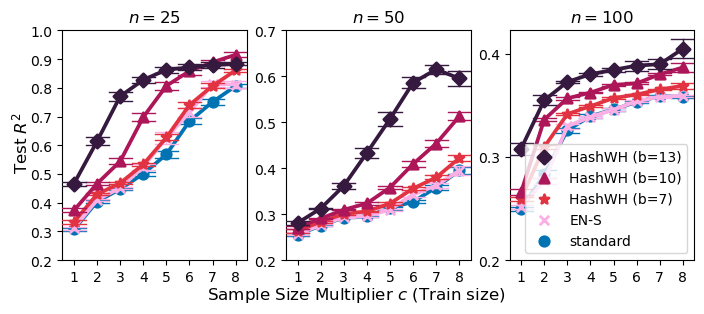

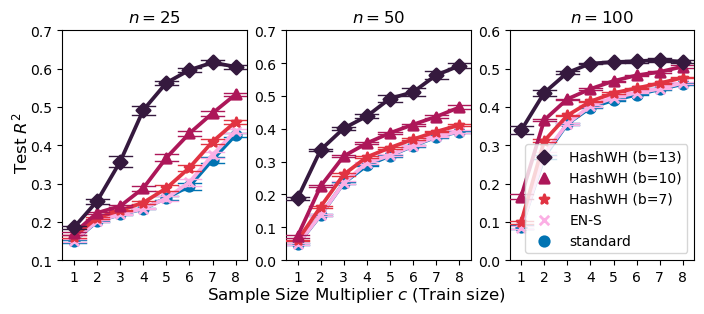

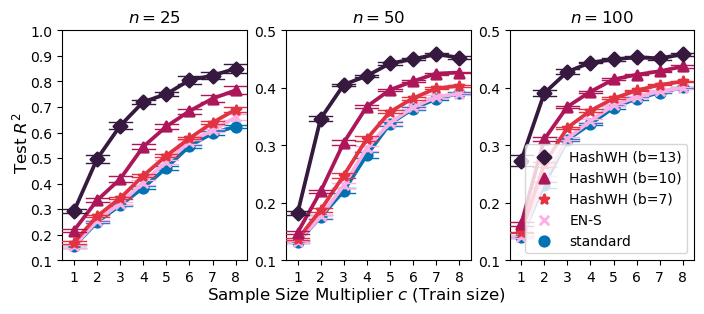

In [66]:

# paper_rc = {'lines.linewidth': 1, 'lines.markersize': 20}                  
# sns.set_context("paper", rc = paper_rc) 

for fix_seed in fix_seeds:
    fig, axes = plt.subplots(1, 3, figsize=(7, 3))
    for i, n in enumerate(ns):
        best_results = n_seeded_best_results[n][str(fix_seed)]
        runtimes = n_seeded_runtimes[n][str(fix_seed)]
        ax = axes[i]
        
        results = {"Training method":[], "Train size": [], "Validation R2": [], "Runtime": []}
        for train_size in dataset_sizes:
            if train_size == 20:
                continue
            best_results_train_size = best_results[str(train_size)]
            runtimes_train_size = runtimes[str(train_size)]
            for training_method in best_results_train_size.keys():
                results["Training method"].extend([training_method] * len(best_results_train_size[training_method]))
                results["Train size"].extend([train_size] * len(best_results_train_size[training_method]))
                results["Validation R2"].extend(best_results_train_size[training_method])
                results["Runtime"].extend(runtimes_train_size[training_method])

        # R2
        g = sns.pointplot(x="Train size", y="Validation R2", hue="Training method",errorbar='se',
                    capsize=1, data=pd.DataFrame.from_dict(results), errwidth=1, markers=markers, ax=ax)
        # ax.set_xlabel("Sample Size Multiplier $c$")
        ax.set_xlabel(None)
        ax.set_title(f"$n={n}$")
        # if i == 0:
        #     ax.set_ylabel("Test $R^2$")
        # else:
        #     ax.set_ylabel(None)
        ax.set_ylabel(None)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_yticks(np.arange((min(ax.get_yticks()) // 0.1)*0.1, max(ax.get_yticks())+0.01, 0.1))

        if i == len(ns)-1:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[::-1], labels=labels[::-1])
        else:
            ax.get_legend().remove()
    fig.supylabel("Test $R^2$", x=0.005, y=0.55)
    fig.supxlabel("Sample Size Multiplier $c$ (Train size)", y=0.01)

    fig.tight_layout(pad=0.15, w_pad=0.5)
    plt.savefig(f'files/synthetic_large/column_performance_seed{fix_seed}.pdf')

point_handle, _ = ax.get_legend_handles_labels()

In [58]:
(0.56 // 0.1) * 0.1

0.5